In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from numpy import array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold

C:\Users\takea\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv(r'C:\Users\takea\Desktop\DeepLearning\datasets\week3\HAR_Dataset\UCI_HAR_Dataset\features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv(r'C:\Users\takea\Desktop\DeepLearning\datasets\week3\HAR_Dataset\UCI_HAR_Dataset\train\X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv(r'C:\Users\takea\Desktop\DeepLearning\datasets\week3\HAR_Dataset\UCI_HAR_Dataset\test\X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv(r'C:\Users\takea\Desktop\DeepLearning\datasets\week3\HAR_Dataset\UCI_HAR_Dataset\train\y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv(r'C:\Users\takea\Desktop\DeepLearning\datasets\week3\HAR_Dataset\UCI_HAR_Dataset\test\y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test, feature_name

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test, feature_name = get_human_dataset()

print("## 학습 피처 데이터 정보 ##")
print(X_train.info())

## 학습 피처 데이터 정보 ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [4]:
print(X_train)

      tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
0              0.288585          -0.020294          -0.132905   
1              0.278419          -0.016411          -0.123520   
2              0.279653          -0.019467          -0.113462   
3              0.279174          -0.026201          -0.123283   
4              0.276629          -0.016570          -0.115362   
...                 ...                ...                ...   
7347           0.299665          -0.057193          -0.181233   
7348           0.273853          -0.007749          -0.147468   
7349           0.273387          -0.017011          -0.045022   
7350           0.289654          -0.018843          -0.158281   
7351           0.351503          -0.012423          -0.203867   

      tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
0            -0.995279         -0.983111         -0.913526         -0.995112   
1            -0.998245         -0.975300         -0.960322 

In [5]:
print(y_train)

      action
0          5
1          5
2          5
3          5
4          5
...      ...
7347       2
7348       2
7349       2
7350       2
7351       2

[7352 rows x 1 columns]


In [6]:
# Scale train/ test predictors based on training data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## 2차원 데이터 -> 3차원 데이터

In [7]:
# Reformat the training data into sequence samples
# Source: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [8]:
# Merge train and test X/y data to apply sequence transformation function
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

# Apply sequence transformation using time step of 25 for both train and test data
# All sensing modalities are recorded at a sampling rate of 50 Hz, which is considered sufficient for capturing human activity.

X_train, y_train = split_sequences(train_set, 25)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 25)
print(X_test.shape, y_test.shape)

(7328, 25, 561) (7328,)
(2923, 25, 561) (2923,)


In [9]:
print(X_train.shape, y_train.shape)

(7328, 25, 561) (7328,)


In [10]:
# Convert output variables to categorical for CNN
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

(7328, 7)
(2923, 7)


In [11]:
# Produce variables for CNN input/output shape
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print(n_timesteps, n_features, n_outputs)

25 561 7


# Training _ static CNN1

In [12]:
# Model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
#model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 64)            107776    
                                                                 
 flatten (Flatten)           (None, 1472)              0         
                                                                 
 dense (Dense)               (None, 128)               188544    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 297223 (1.13 MB)
Trainable params: 297223 (1.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# validation_split = 0.1
train_epochs = 10
history = model.fit(X_train, y_train, epochs=train_epochs, verbose=True)

Epoch 1/10
229/229 [==============================] - 5s 14ms/step - loss: 0.3011 - accuracy: 0.8952
Epoch 2/10
229/229 [==============================] - 4s 16ms/step - loss: 0.0538 - accuracy: 0.9814
Epoch 3/10
229/229 [==============================] - 3s 14ms/step - loss: 0.0375 - accuracy: 0.9889
Epoch 4/10
229/229 [==============================] - 3s 14ms/step - loss: 0.0433 - accuracy: 0.9906
Epoch 5/10
229/229 [==============================] - 3s 14ms/step - loss: 0.1067 - accuracy: 0.9782
Epoch 6/10
229/229 [==============================] - 3s 13ms/step - loss: 0.0270 - accuracy: 0.9934
Epoch 7/10
229/229 [==============================] - 3s 14ms/step - loss: 0.0054 - accuracy: 0.9992
Epoch 8/10
229/229 [==============================] - 3s 13ms/step - loss: 7.2921e-04 - accuracy: 0.9996
Epoch 9/10
229/229 [==============================] - 3s 14ms/step - loss: 7.0205e-04 - accuracy: 0.9997
Epoch 10/10
229/229 [==============================] - 3s 14ms/step - loss: 9.3942e

KeyError: 'val_accuracy'

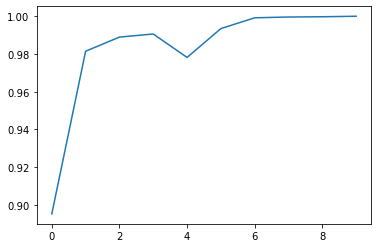

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
y_pred = y_pred.reshape(-1,1)
y_pred.shape

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=model.predict([X_test])
pred=np.argmax(pred, axis=-1)
y_test2=np.argmax(y_test, axis=-1)
cm=confusion_matrix(y_test2,pred)
print(cm)
print(accuracy_score(y_test2,pred))
print(classification_report(y_test2,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')